## Hello, you ;)
This is a notebook for testing project ideas and ugly EDA stuff
- **FOR AUTHORIZED EYES ONLY**
    - or not idrc

In [10]:
# there have been changes to the shapely/geopandas combo
# this fixes an error warning
import os
os.environ['USE_PYGEOS'] = '0'

In [3]:
# !pip install geopandas
# !pip install mapclassify
import geopandas as gpd
import mapclassify
import shapely
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [12]:
pd.set_option('display.max_columns', 150)

In [13]:
# load review data
reviews = pd.read_csv('../inputs/reviews.csv.gz', compression='gzip')
reviews["date"] = pd.to_datetime(reviews["date"])
reviews = reviews.drop('id', axis=1)

In [4]:
# load calander data
calendar = pd.read_csv('../inputs/calendar.csv.gz', compression='gzip')
calendar["date"] = pd.to_datetime(calendar["date"])

In [5]:
calendar

listing_id       date available    price adjusted_price  \
0              3781 2023-03-19         f  $125.00        $125.00   
1              3781 2023-03-20         f  $125.00        $125.00   
2              3781 2023-03-21         f  $125.00        $125.00   
3              3781 2023-03-22         f  $125.00        $125.00   
4              3781 2023-03-23         f  $125.00        $125.00   
...             ...        ...       ...      ...            ...   
1410018     2021483 2024-03-13         f  $500.00        $500.00   
1410019     2021483 2024-03-14         f  $500.00        $500.00   
1410020     2021483 2024-03-15         f  $500.00        $500.00   
1410021     2021483 2024-03-16         f  $500.00        $500.00   
1410022     2021483 2024-03-17         f  $500.00        $500.00   

         minimum_nights  maximum_nights  
0                  32.0          1125.0  
1                  32.0          1125.0  
2                  32.0          1125.0  
3                  32.0          1125.0  
4                  32.0          1125.0  
...                 ...             ...  
1410018             1.0          1125.0  
1410019             1.0          1125.0  
1410020             1.0          1125.0  
1410021             1.0          1125.0  
1410022             1.0          1125.0  

[1410023 rows x 7 columns]

In [15]:
# Boston airbnb listings data
listings = pd.read_csv('../inputs/listings.csv.gz', compression='gzip')

In [16]:
# testing the combination of review and listing data (This is all reviews for each listing)
test_merge = pd.merge(listings, reviews.rename(columns={"listing_id":"id", "date":"review_date"}), on='id', how='left')

In [17]:
# testing combination of calendar and listing data (HELPFUL | This is all listing data on each date into the next year)
test_merge2 = pd.merge(calendar.rename(columns={"listing_id":"id"}), listings.rename(columns={"price":"3/2023_price"}), on='id', how='left')

In [18]:
# load census tract data for boston
tract_data = pd.read_csv("../inputs/census-tract-data.csv")

In [19]:
# load census neighborhood data for boston
neighborhood_data = pd.read_csv("../inputs/boston-neighborhood-data.csv")

In [20]:
calendar['date'].min()

Timestamp('2023-03-19 00:00:00')

In [21]:
calendar['date'].max()

Timestamp('2024-03-18 00:00:00')

In [22]:
reviews['date'].min()

Timestamp('2009-03-21 00:00:00')

In [23]:
reviews['date'].max()

Timestamp('2023-03-19 00:00:00')

In [24]:
listings['last_scraped'].min()

'2023-03-19'

In [25]:
listings['last_scraped'].max()

'2023-03-20'

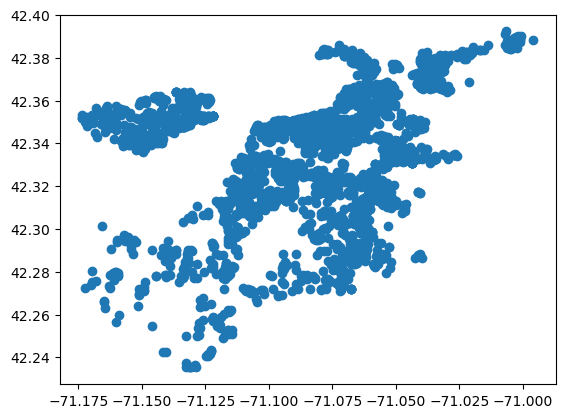

In [26]:
# this is where every Airbnb listing is in our data set (no map tho)
plt.scatter(listings['longitude'], listings['latitude'])

In [27]:
# gotta get a map of tracts
boston_tract = gpd.read_file("../inputs/Census2020_Tracts/Census2020_Tracts.shp")


In [28]:
# these coordinates are not standard
boston_tract['geometry'].head()

0    POLYGON ((757373.036 2913676.433, 757377.218 2...
1    POLYGON ((756308.459 2916770.814, 756446.058 2...
2    POLYGON ((757682.058 2924622.055, 757807.152 2...
3    POLYGON ((753408.502 2925331.042, 753418.584 2...
4    POLYGON ((759003.960 2926858.165, 759043.379 2...
Name: geometry, dtype: geometry

In [29]:
# set to the standard longitute/latitude system
boston_tract = boston_tract.to_crs('epsg:4326')

In [30]:
# much better
boston_tract['geometry'].head()

0    POLYGON ((-71.12623 42.24267, -71.12621 42.244...
1    POLYGON ((-71.13012 42.25117, -71.12960 42.251...
2    POLYGON ((-71.12491 42.27270, -71.12445 42.273...
3    POLYGON ((-71.14069 42.27470, -71.14065 42.275...
4    POLYGON ((-71.11999 42.27882, -71.11984 42.279...
Name: geometry, dtype: geometry

<AxesSubplot:>

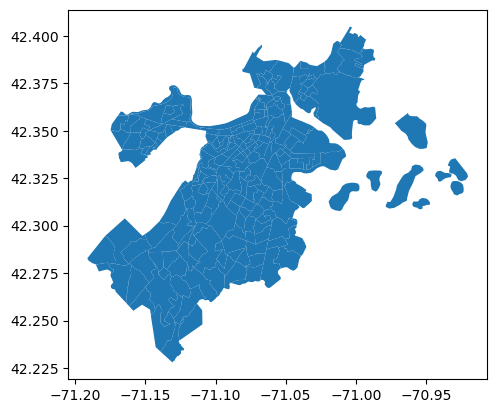

In [31]:
# census tracts map
boston_tract.plot()

In [78]:
# this step maps each longitude and latitude to a shapely point
listings = gpd.GeoDataFrame(listings, geometry=listings.apply(
        lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'
    ))

In [33]:
# function to create a new column based on whether or not a listing is in a tract
def assign_census_tract(bnb):
    bools = [geom.contains(bnb['geometry']) for geom in boston_tract['geometry']]
    if True in bools:
        return boston_tract.iloc[bools.index(True)]['NAME20']
    else:
        return np.nan

In [34]:
# .apply the function to the listings
listings['census_tract'] = listings.apply(assign_census_tract, axis='columns')

In [35]:
# this is how many listings are in each census tract
listings['census_tract'].value_counts().head()

702.02    105
907        98
701.02     92
814        87
701.04     87
Name: census_tract, dtype: int64

In [36]:
# use .map() to apply value_counts to each value of 'NAME20'
boston_tract['BNBs'] = boston_tract['NAME20'].map(listings['census_tract'].value_counts())
boston_tract['BNBs'] = boston_tract['BNBs'].fillna(0)
boston_tract.set_index('NAME20', inplace=True)

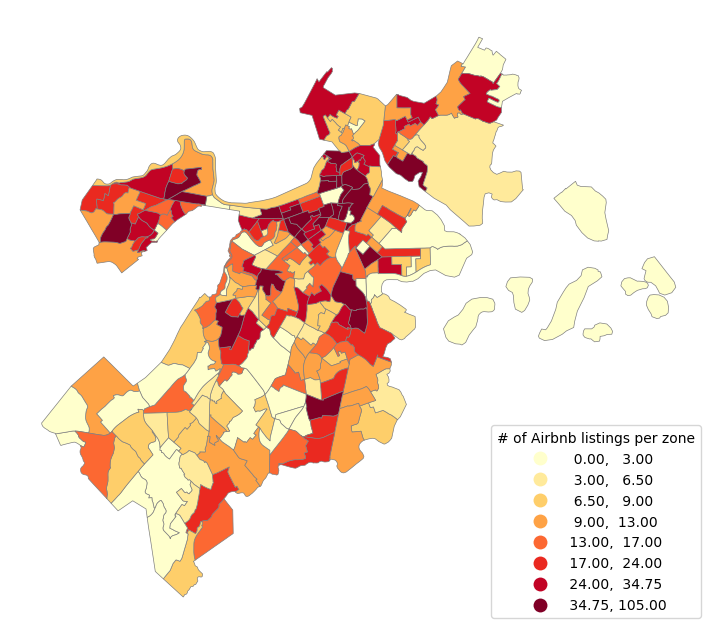

In [37]:
# what a nice choropleth map
# it shows the amount of listings in each zone
# but its not scaled for population density
f = plt.figure(figsize=(9,9.15))
ax = f.gca()
kw = dict(column='BNBs', k=8, cmap='YlOrRd', edgecolor='gray', linewidth=0.5)
boston_tract.plot(scheme='QUANTILES', ax=ax, **kw, legend=True, legend_kwds={'loc': 'lower right', 'title': '# of Airbnb listings per zone'})
ax.set_axis_off()

In [38]:
# this code reprojects the areas into an "equal-area" projection
# this is so that I can get listings per Kilometer^2
boston_tract['BNBDensity'] = (boston_tract['BNBs'] / boston_tract['geometry']\
                            .to_crs('epsg:3395')\
                            .map(lambda p: p.area / 10**6))\
                            .fillna(0)

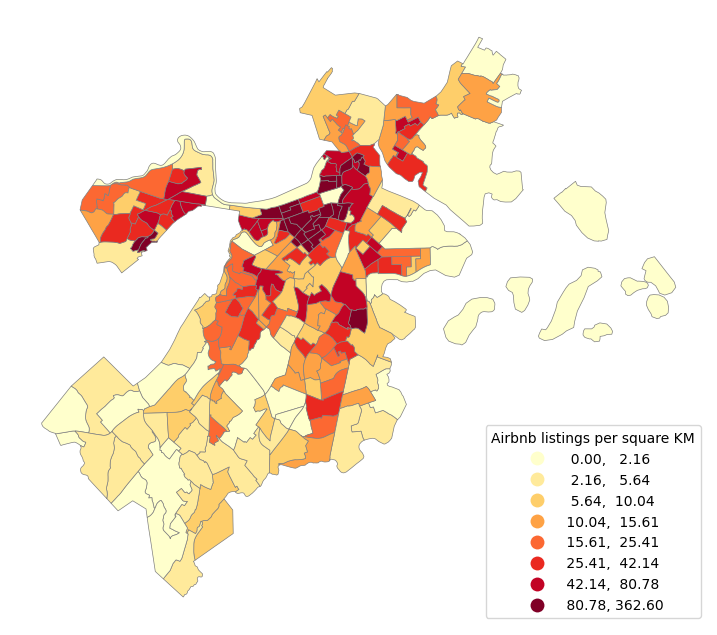

In [39]:
# this graph represents listings per square KM as census tracts
f = plt.figure(figsize=(9, 9))
ax = f.gca()
kw = dict(column='BNBDensity', k=8, cmap='YlOrRd', edgecolor='gray', linewidth=0.5)
boston_tract.plot(scheme='QUANTILES', ax=ax, **kw, legend=True, legend_kwds={'loc': 'lower right', 'title': "Airbnb listings per square KM"})
ax.set_axis_off()

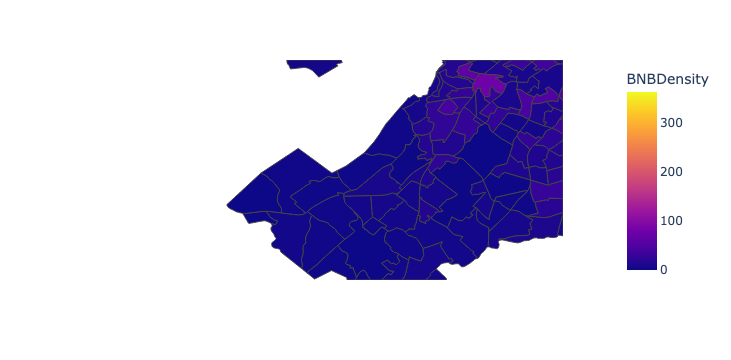

In [40]:
# a nicer (and interactive) choropleth map using plotly
fig = px.choropleth(boston_tract, geojson=boston_tract.geometry, locations=boston_tract.index, color="BNBDensity")
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

### Next I will do the same but with neighborhood data. Mostly as a test

In [41]:
# map of neighborhoods
boston_NBH = gpd.read_file("../inputs/Census2020_BG_Neighborhoods/Census2020_BG_Neighborhoods.shp")

In [42]:
# gotta make same fix for CRS as above
boston_NBH = boston_NBH.to_crs('epsg:4326')

<AxesSubplot:>

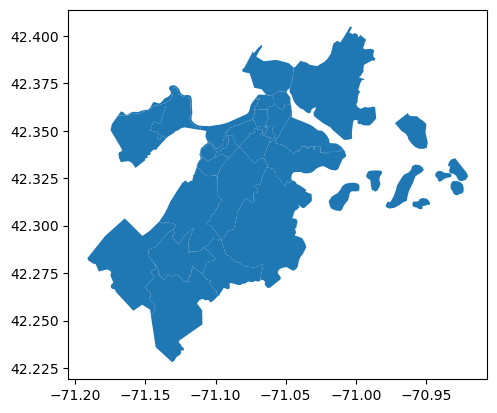

In [43]:
# neighborhood map
boston_NBH.plot()

In [44]:
# function to create a new column based on whether or not a listing is in a neighborhood
def assign_census_NBH(bnb):
    bools = [geom.contains(bnb['geometry']) for geom in boston_NBH['geometry']]
    if True in bools:
        return boston_NBH.iloc[bools.index(True)]['BlockGr202']
    else:
        return np.nan

In [45]:
# .apply the function to the listings
listings['census_NBH'] = listings.apply(assign_census_NBH, axis='columns')

In [46]:
# this is how many listings are in each Neighborhood
listings['census_NBH'].value_counts().head()

Dorchester    512
South End     327
Downtown      307
Roxbury       292
Brighton      284
Name: census_NBH, dtype: int64

In [47]:
# use .map() to apply value_counts to each value of 'BlockGr202'
boston_NBH['BNBs'] = boston_NBH['BlockGr202'].map(listings['census_NBH'].value_counts())
boston_NBH['BNBs'] = boston_NBH['BNBs'].fillna(0)
boston_NBH.set_index('BlockGr202', inplace=True)

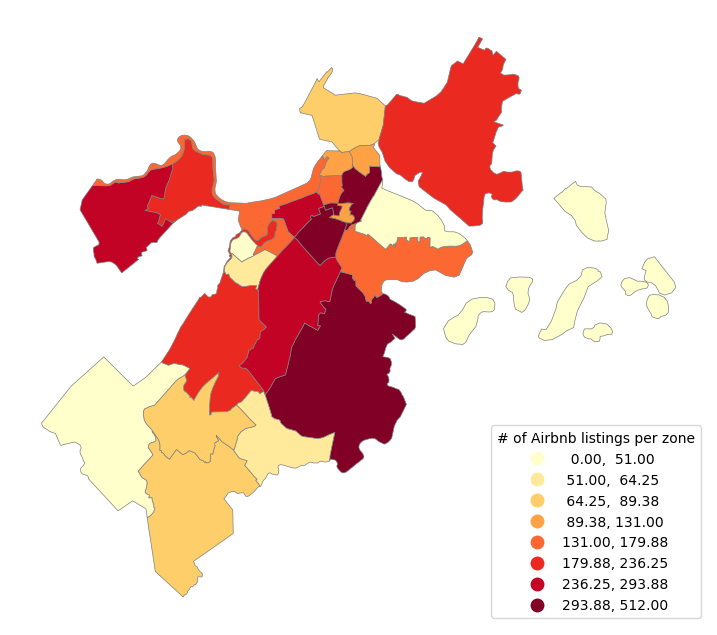

In [48]:
# choropleth map for neighborhoods
# disregards population density
f = plt.figure(figsize=(9,9.15))
ax = f.gca()
kw = dict(column='BNBs', k=8, cmap='YlOrRd', edgecolor='gray', linewidth=0.5)
boston_NBH.plot(scheme='QUANTILES', ax=ax, **kw, legend=True, legend_kwds={'loc': 'lower right', 'title': '# of Airbnb listings per zone'})
ax.set_axis_off()

In [49]:
# this code reprojects the areas into an "equal-area" projection
# this is so that I can get listings per Kilometer^2
boston_NBH['BNBDensity'] = (boston_NBH['BNBs'] / boston_NBH['geometry']\
                            .to_crs('epsg:3395')\
                            .map(lambda p: p.area / 10**6))\
                            .fillna(0)

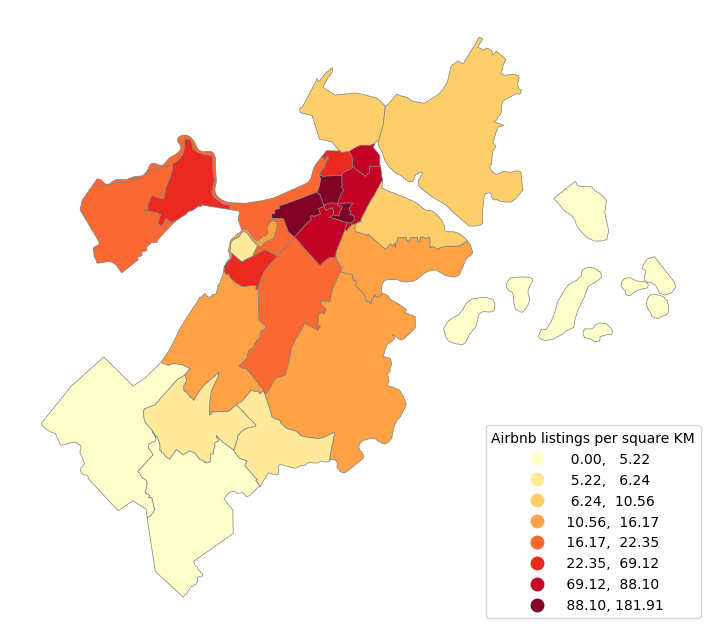

In [50]:
# this graph represents listings per square KM as Neighborhoods
f = plt.figure(figsize=(9, 9))
ax = f.gca()
kw = dict(column='BNBDensity', k=8, cmap='YlOrRd', edgecolor='gray', linewidth=0.5)
boston_NBH.plot(scheme='QUANTILES', ax=ax, **kw, legend=True, legend_kwds={'loc': 'lower right', 'title': "Airbnb listings per square KM"})
ax.set_axis_off()

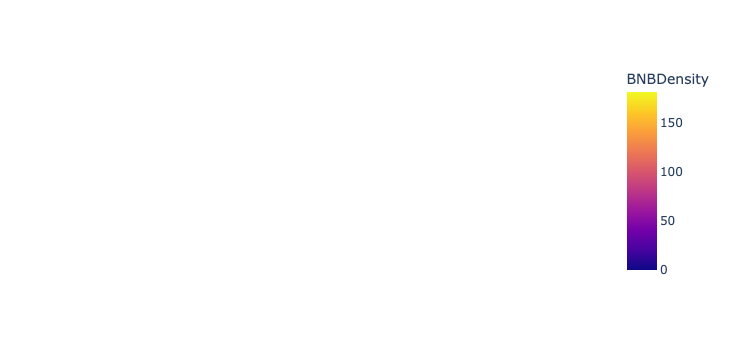

In [51]:
# trying to make clicking available (doesn't seem worth it here)
# ended up being very helpful for default select
fig = px.choropleth(boston_NBH, 
                    geojson=boston_NBH['geometry'], 
                    locations=boston_NBH.index, 
                    color="BNBDensity",
                    custom_data=['BNBs'])

fig.update_geos(fitbounds="locations", visible=False)

fig.update_traces(hovertemplate='<b>%{location}</b><br>' +
                                 'BNB Density: %{z}<br>' +
                                 '# of BNB listings: %{customdata}',
                                 selectedpoints=list(range(len(boston_NBH))))

fig.show()

In [52]:
# OLDER Boston airbnb listings data for test
listings_old = pd.read_csv('../inputs/listings_2022.csv.gz', compression='gzip')

In [53]:
calendar_old = pd.read_csv('../inputs/calendar_2022.csv.gz', compression='gzip')

In [54]:
calendar_old['date'].min()

'2022-06-13'

In [55]:
calendar_old['date'].max()

'2023-06-12'

In [56]:
merged = pd.merge(listings['id'], listings_old['id'], on='id')

# count the number of rows in the merged DataFrame
common_count = len(merged)

print(common_count)

2617


In [57]:
# # trying out diplay with dash (seems like alternative to streamlit, so not that helpful)
# # yes, it is suppose to run forever... click the link below to see output
# # if you make a change and want to see output again:
# #        - re-run this cell, then interrupt kernel

# fig = px.choropleth(boston_NBH, geojson=boston_NBH.geometry, locations=boston_NBH.index, color="BNBDensity")
# fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(clickmode='event+select')

# import dash
# from dash import dcc
# from dash import html

# app = dash.Dash()
# app.layout = html.Div([
#     dcc.Graph(figure=fig)
# ])

# app.run_server(debug=True, use_reloader=False)

In [58]:
listings['census_NBH'].value_counts()

Dorchester                 512
South End                  327
Downtown                   307
Roxbury                    292
Brighton                   284
Back Bay                   267
East Boston                226
Jamaica Plain              225
Allston                    198
South Boston               169
Beacon Hill                167
Fenway                     156
Chinatown                  106
North End                  100
West End                    98
Charlestown                 75
Hyde Park                   66
Roslindale                  66
Mission Hill                59
Mattapan                    55
South Boston Waterfront     51
West Roxbury                51
Longwood                     7
Name: census_NBH, dtype: int64

In [59]:
listings['neighbourhood_cleansed'].value_counts()

Dorchester                 511
Downtown                   351
Roxbury                    291
Brighton                   290
Back Bay                   275
South End                  264
East Boston                226
Jamaica Plain              215
Allston                    192
South Boston               170
Beacon Hill                169
Fenway                     163
North End                  107
Chinatown                   99
Charlestown                 75
Roslindale                  67
Hyde Park                   65
Mission Hill                64
Mattapan                    55
Bay Village                 53
South Boston Waterfront     51
West Roxbury                51
West End                    47
Leather District             8
Longwood Medical Area        5
Name: neighbourhood_cleansed, dtype: int64

In [60]:
# good prices on the whole dataframe
listings['price'] = listings['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))

In [61]:
# filter by neighborhood
listings_filt = listings.loc[listings['census_NBH'] == 'East Boston'].reset_index()

In [62]:
# making sure fix to prices worked
listings_filt['price']

0      132.0
1       48.0
2      195.0
3      125.0
4      100.0
       ...  
221    225.0
222    187.0
223     60.0
224     42.0
225    257.0
Name: price, Length: 226, dtype: float64

In [63]:
# good prices as floats
# listings_filt['price'] = listings_filt['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))

In [64]:
listings_filt['price'].max()

388.0

In [65]:
listings_filt['price'].min()

28.0

In [66]:
# exporting complete map data for a faster website (needs more data probs//could be combined with master somehow)

# once we have a "master data set" that is indexed with neighborhood/tract, we merge

boston_tract.to_csv('../outputs/boston_tract.csv')
boston_NBH.to_csv('../outputs/boston_NBH.csv')

In [67]:
# 3/19/2023 - 3/18/2024 in months
start_date = pd.to_datetime('2023-03-19')
end_date = pd.to_datetime('2024-03-18')
dates = pd.date_range(start=start_date, end=end_date, freq='MS')
date_strings = [str(date.date()) for date in dates]

# playing around

Starting to "master dataset" (maybe?)
- at the very least, making temp csv for Graphics file
    - relevance: vacancy rate data, short/long term rental data, room type data

In [68]:
calendar

listing_id       date available    price adjusted_price  \
0              3781 2023-03-19         f  $125.00        $125.00   
1              3781 2023-03-20         f  $125.00        $125.00   
2              3781 2023-03-21         f  $125.00        $125.00   
3              3781 2023-03-22         f  $125.00        $125.00   
4              3781 2023-03-23         f  $125.00        $125.00   
...             ...        ...       ...      ...            ...   
1410018     2021483 2024-03-13         f  $500.00        $500.00   
1410019     2021483 2024-03-14         f  $500.00        $500.00   
1410020     2021483 2024-03-15         f  $500.00        $500.00   
1410021     2021483 2024-03-16         f  $500.00        $500.00   
1410022     2021483 2024-03-17         f  $500.00        $500.00   

         minimum_nights  maximum_nights  
0                  32.0          1125.0  
1                  32.0          1125.0  
2                  32.0          1125.0  
3                  32.0          1125.0  
4                  32.0          1125.0  
...                 ...             ...  
1410018             1.0          1125.0  
1410019             1.0          1125.0  
1410020             1.0          1125.0  
1410021             1.0          1125.0  
1410022             1.0          1125.0  

[1410023 rows x 7 columns]

In [69]:
listings

id                           listing_url       scrape_id  \
0        3781     https://www.airbnb.com/rooms/3781  20230319180919   
1        5506     https://www.airbnb.com/rooms/5506  20230319180919   
2        6695     https://www.airbnb.com/rooms/6695  20230319180919   
3        8789     https://www.airbnb.com/rooms/8789  20230319180919   
4     4765070  https://www.airbnb.com/rooms/4765070  20230319180919   
...       ...                                   ...             ...   
3859  1956275  https://www.airbnb.com/rooms/1956275  20230319180919   
3860  2000797  https://www.airbnb.com/rooms/2000797  20230319180919   
3861  2014651  https://www.airbnb.com/rooms/2014651  20230319180919   
3862  2014882  https://www.airbnb.com/rooms/2014882  20230319180919   
3863  2021483  https://www.airbnb.com/rooms/2021483  20230319180919   

     last_scraped           source  \
0      2023-03-19      city scrape   
1      2023-03-19      city scrape   
2      2023-03-19      city scrape   
3      2023-03-20      city scrape   
4      2023-03-19      city scrape   
...           ...              ...   
3859   2023-03-20  previous scrape   
3860   2023-03-19      city scrape   
3861   2023-03-19      city scrape   
3862   2023-03-19      city scrape   
3863   2023-03-19      city scrape   

                                                   name  \
0                             HARBORSIDE-Walk to subway   
1        ** Fort Hill Inn Private! Minutes to center!**   
2         Fort Hill Inn *Sunny* 1 bedroom, condo duplex   
3                   Curved Glass Studio/1bd facing Park   
4               Studio w/ private entrance and bathroom   
...                                                 ...   
3859  Beautiful 3 bd- 1.5 bath with parking, in Boston.   
3860  Private balcony&kitchenette, 15min to ctr,safe st   
3861                        One Private Bedroom in J.P.   
3862                     1 bedroom and private bathroom   
3863        Spacious Updated 2 Bed Boston Condo w/ Deck   

                                            description  \
0     Fully separate apartment in a two apartment bu...   
1     Private guest room with private bath, You do n...   
2     Comfortable,  Fully Equipped private apartment...   
3     This unit is for sale. There will need to be o...   
4     Private Studio located in Boston (town of Jama...   
...                                                 ...   
3859  Beautiful & spacious 3 Bedrooms, 1.5 baths wit...   
3860  Charming Victorian hill-top house, pleasant sa...   
3861  Private bedroom on third floor of three family...   
3862  A country feel in Brighton center. Upstairs tw...   
3863  Rent 2 bed/2 bath/2 living rooms in South Bost...   

                                  neighborhood_overview  \
0     Mostly quiet ( no loud music, no crowed sidewa...   
1     Peaceful, Architecturally interesting, histori...   
2     Peaceful, Architecturally interesting, histori...   
3     Beacon Hill is a historic neighborhood filled ...   
4     Jamaica Plain (JP) is an open, artsy, hip neig...   
...                                                 ...   
3859  The neighborhood is Jamaica Plain, great for w...   
3860  Jones Hill is a quiet, safe residential neighb...   
3861  From the Boston Globe;<br /><br />JAMAICA PLAI...   
3862  This is a quiet suburban neighborhood which is...   
3863                                                NaN   

                                            picture_url   host_id  \
0     https://a0.muscache.com/pictures/24670/b2de044...      4804   
1     https://a0.muscache.com/pictures/miso/Hosting-...      8229   
2     https://a0.muscache.com/pictures/38ac4797-e7a4...      8229   
3     https://a0.muscache.com/pictures/miso/Hosting-...     26988   
4     https://a0.muscache.com/pictures/miso/Hosting-...  24584716   
...                                                 ...       ...   
3859  https://a0.muscache.com/pictures/42671192/d68d...   9622924   
3860  https://a0.musca

In [70]:
listings_short = listings[['id','room_type','minimum_nights','census_tract','census_NBH']]
listings_short

id        room_type  minimum_nights census_tract     census_NBH
0        3781  Entire home/apt              32          512    East Boston
1        5506  Entire home/apt               3          814        Roxbury
2        6695  Entire home/apt               3          814        Roxbury
3        8789  Entire home/apt              91       203.02    Beacon Hill
4     4765070  Entire home/apt               3          812  Jamaica Plain
...       ...              ...             ...          ...            ...
3859  1956275  Entire home/apt              91      1201.05  Jamaica Plain
3860  2000797     Private room               2          912     Dorchester
3861  2014651     Private room              91      1202.01  Jamaica Plain
3862  2014882     Private room               3         4.02       Brighton
3863  2021483  Entire home/apt               1          608   South Boston

[3864 rows x 5 columns]

In [71]:
listings_short.to_csv('../inputs/master_short.csv', index = False)

In [72]:
calendar

listing_id       date available    price adjusted_price  \
0              3781 2023-03-19         f  $125.00        $125.00   
1              3781 2023-03-20         f  $125.00        $125.00   
2              3781 2023-03-21         f  $125.00        $125.00   
3              3781 2023-03-22         f  $125.00        $125.00   
4              3781 2023-03-23         f  $125.00        $125.00   
...             ...        ...       ...      ...            ...   
1410018     2021483 2024-03-13         f  $500.00        $500.00   
1410019     2021483 2024-03-14         f  $500.00        $500.00   
1410020     2021483 2024-03-15         f  $500.00        $500.00   
1410021     2021483 2024-03-16         f  $500.00        $500.00   
1410022     2021483 2024-03-17         f  $500.00        $500.00   

         minimum_nights  maximum_nights  
0                  32.0          1125.0  
1                  32.0          1125.0  
2                  32.0          1125.0  
3                  32.0          1125.0  
4                  32.0          1125.0  
...                 ...             ...  
1410018             1.0          1125.0  
1410019             1.0          1125.0  
1410020             1.0          1125.0  
1410021             1.0          1125.0  
1410022             1.0          1125.0  

[1410023 rows x 7 columns]

In [73]:
master = pd.merge(calendar.rename(columns={"listing_id":"id"}).drop('minimum_nights', axis=1),
                  listings_short,
                  how = 'left',
                  on = 'id')
master = master.drop(columns=['adjusted_price', 'maximum_nights'])
master['price'] = master['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
master

id       date available  price        room_type  minimum_nights  \
0           3781 2023-03-19         f  125.0  Entire home/apt              32   
1           3781 2023-03-20         f  125.0  Entire home/apt              32   
2           3781 2023-03-21         f  125.0  Entire home/apt              32   
3           3781 2023-03-22         f  125.0  Entire home/apt              32   
4           3781 2023-03-23         f  125.0  Entire home/apt              32   
...          ...        ...       ...    ...              ...             ...   
1410018  2021483 2024-03-13         f  500.0  Entire home/apt               1   
1410019  2021483 2024-03-14         f  500.0  Entire home/apt               1   
1410020  2021483 2024-03-15         f  500.0  Entire home/apt               1   
1410021  2021483 2024-03-16         f  500.0  Entire home/apt               1   
1410022  2021483 2024-03-17         f  500.0  Entire home/apt               1   

        census_tract    census_NBH  
0                512   East Boston  
1                512   East Boston  
2                512   East Boston  
3                512   East Boston  
4                512   East Boston  
...              ...           ...  
1410018          608  South Boston  
1410019          608  South Boston  
1410020          608  South Boston  
1410021          608  South Boston  
1410022          608  South Boston  

[1410023 rows x 8 columns]

In [74]:
master.to_csv('../inputs/master.csv', index = False)